In [9]:
%matplotlib inline
import re
from pathlib import Path

import numpy as np

from spectrometer import FID1D, plot, process

In [10]:
# Load raw *.fid data
fids: list[FID1D] = []
for file in Path("../data/20230825-133535-Water-1H-t2-decay").glob("*.fid"):
    fids.append(FID1D.from_file(file))

# Extract pulse lengths from metadata
pattern = r"delay_tau=(.*)us,repetition"
delays_tau_us = [float(re.search(pattern, str(fid.pulse))[1]) for fid in fids]

# Sort data by tau delays
delays_tau_us, fids = zip(*sorted(zip(delays_tau_us, fids)))
delays_tau_ms = np.array(delays_tau_us) / 1000

In [11]:
# Make numpy arrays with the data
fids_data = np.array([fid.data for fid in fids])
fids_time = np.array([fid.us_scale for fid in fids]) / 1000
fids_tau = np.repeat(delays_tau_ms[:, np.newaxis], fids_data.shape[1], axis=-1)

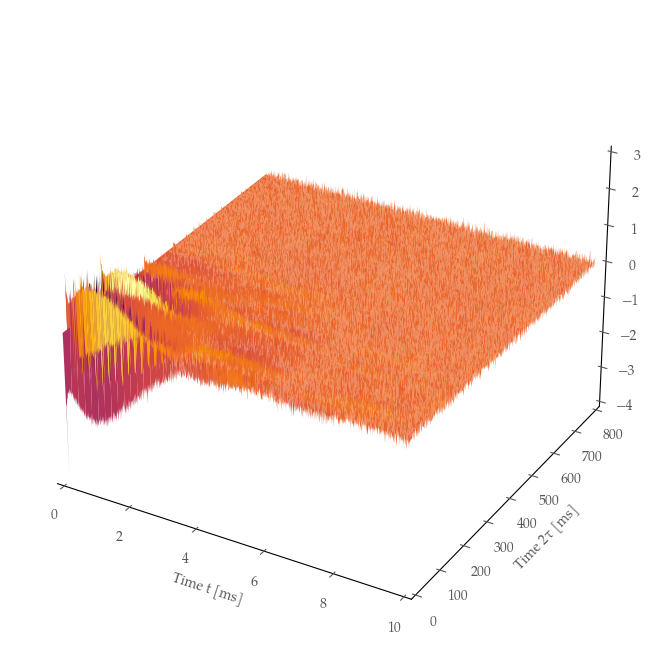

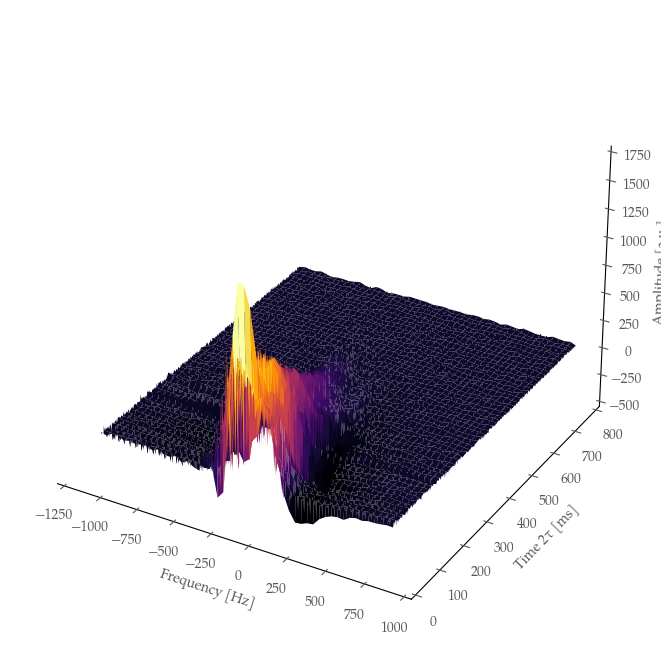

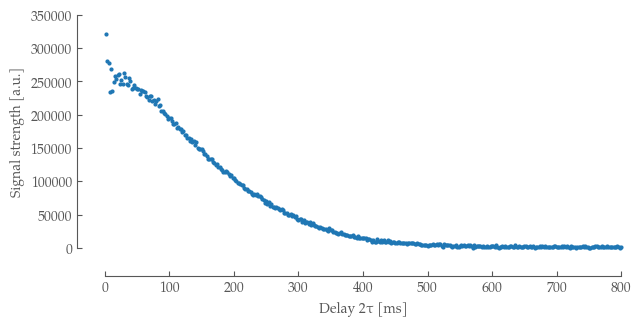

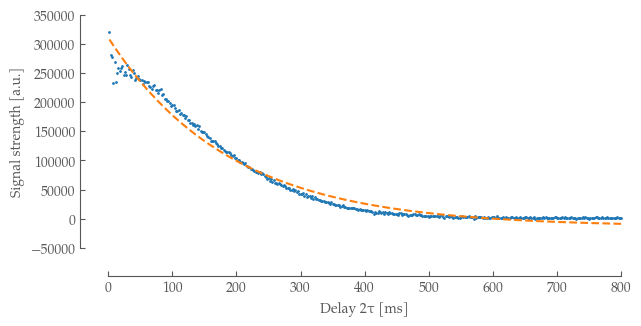

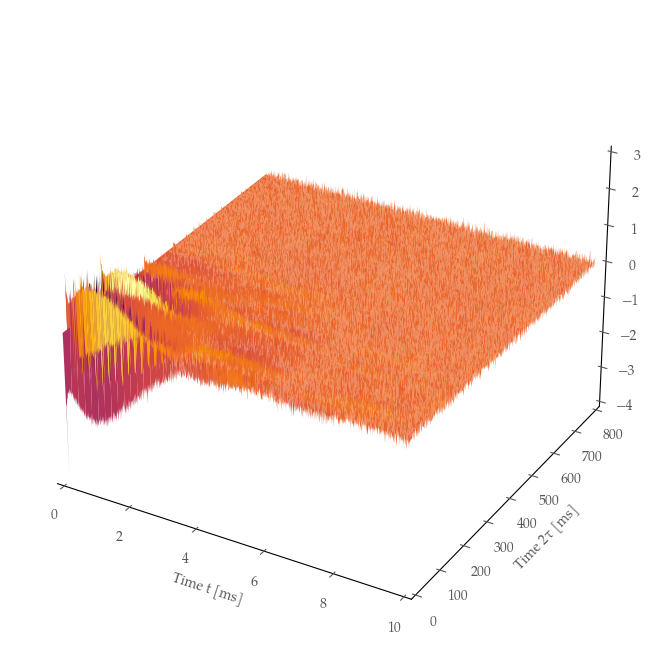

In [12]:
# Plot raw data 3D
cm = 1 / 2.54
fig, axes = plot.subplots3d(figsize=(16 * cm, 16 * cm))

# Factor of two, because the spins decay since the first 90 degree pulse
axes.plot_surface(
    fids_time, 2 * fids_tau, fids_data.real, antialiased=True, cmap="inferno"
)

axes.set_xlabel("Time t [ms]")
axes.set_ylabel("Time 2τ [ms]")
axes.set_zlabel("Amplitude [a.u.]")

plot.format_axes3d(axes)
fig.subplots_adjust(-0.11, 0, 1, 1)
fig.savefig(
    "t2_decay_3d.pdf",
    bbox_inches=fig.bbox_inches.from_bounds(0, 0, 16 * cm, 13 * cm),
    pad_inches=0,
)

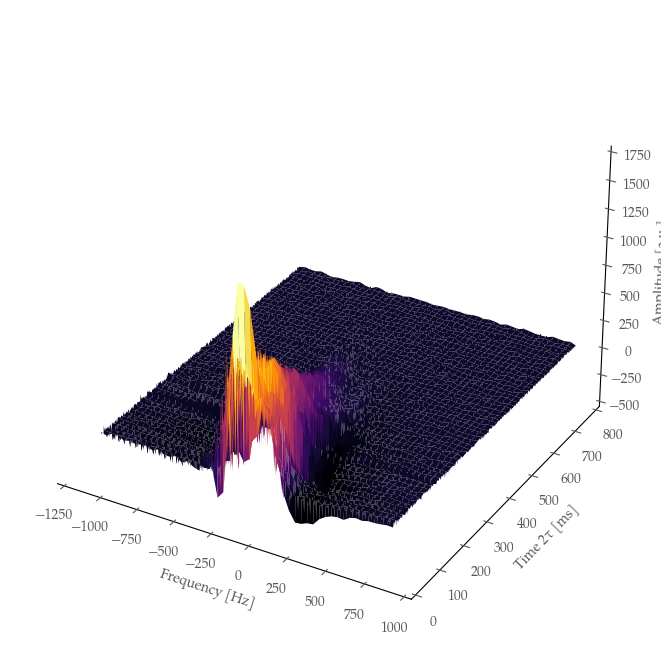

In [13]:
fids_fft = np.array([fid.spectrum()[0] for fid in fids])
fid_scales = np.array([fid_fft.hz.scale for fid_fft in fids_fft])
fid_ffts = np.array([fid_fft[:] for fid_fft in fids_fft])
fid_taus = np.repeat(delays_tau_ms[:, np.newaxis], fid_scales.shape[1], axis=-1)

# Find max in first fid
peak_pos = np.argmax(np.abs(fid_ffts))

# Crop data around peak
peak_width = 50
fid_scales_crop = fid_scales[:, peak_pos - peak_width // 2 : peak_pos + peak_width // 2]
fid_taus_crop = fid_taus[:, peak_pos - peak_width // 2 : peak_pos + peak_width // 2]
fid_ffts_crop = fid_ffts[:, peak_pos - peak_width // 2 : peak_pos + peak_width // 2]

# Plot raw data 3D
cm = 1 / 2.54
fig, axes = plot.subplots3d(figsize=(16 * cm, 16 * cm))

# Factor of two, because the spins decay since the first 90 degree pulse
axes.plot_surface(
    fid_scales_crop,
    2 * fid_taus_crop,
    fid_ffts_crop.real,
    cmap="inferno",
    linestyle="",
    linewidth=0,
)  # , antialiased=True)

axes.set_xlabel("Frequency [Hz]")
axes.set_ylabel("Time 2τ [ms]")
axes.set_zlabel("Amplitude [a.u.]")

plot.format_axes3d(axes)
fig.subplots_adjust(-0.11, 0, 1, 1)
fig.savefig(
    "t2_decay_3d_fft.pdf",
    bbox_inches=fig.bbox_inches.from_bounds(0, 0, 16 * cm, 13 * cm),
    pad_inches=0,
)

In [14]:
# Estimate width of first peak
fit_lorentz = process.lorentz.fit(fid_scales[0], np.abs(fid_ffts[0]))
peak_width = int(np.ceil(fit_lorentz.fwhm / (fid_scales[0][0] - fid_scales[0][1]))) * 2
print(f"Estimated Full Width at Half Maximum in indexes: {peak_width}")
print(f"Estimated peak location index: {peak_pos}")

# Crop data around peak
fid_scales_crop = fid_scales[:, peak_pos - peak_width // 2 : peak_pos + peak_width // 2]
fid_taus_crop = fid_taus[:, peak_pos - peak_width // 2 : peak_pos + peak_width // 2]
fid_ffts_crop = fid_ffts[:, peak_pos - peak_width // 2 : peak_pos + peak_width // 2]

# Integrate peaks
signal_strengths = np.trapz(x=np.flip(fid_scales_crop), y=np.flip(fid_ffts_crop))

Estimated Full Width at Half Maximum in indexes: 20
Estimated peak location index: 4098


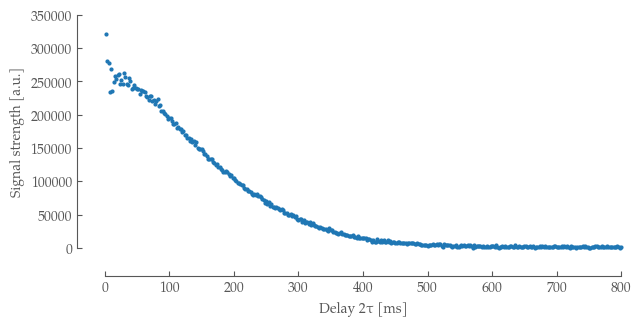

In [15]:
amplitudes = np.abs(signal_strengths)
scale = np.flip(delays_tau_ms) * 2
scale, amplitudes = zip(*sorted(zip(scale, amplitudes)))

# Plot raw data
cm = 1 / 2.54
fig, axes = plot.subplots(
    figsize=(16.0 * cm, 8.0 * cm),  # Wide Layout: ~16cm, Margin Layout: 10.7cm
)
axes.plot(
    scale,
    amplitudes,
    linestyle="",
    marker="o",
    markersize=2,
)
axes.set_ylabel("Signal strength [a.u.]")
axes.set_xlabel("Delay 2τ [ms]")

plot.format_axes(axes)

fig.savefig("t2_decay.pdf")

Amplitude: 324603.7372673836
Offset: -13511.189804778858
Lambda: 0.005279667695836789 kHz
T2: 189.40585991586866 ms


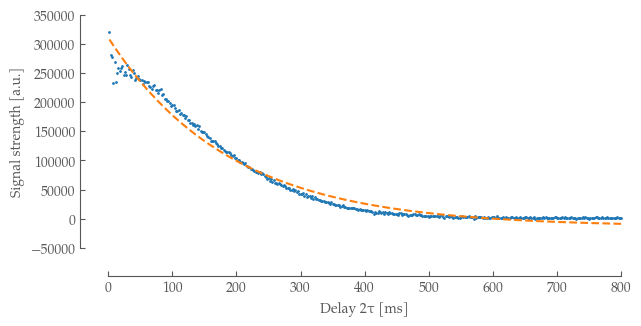

In [16]:
# Plot raw values again first
cm = 1 / 2.54
fig, axes = plot.subplots(
    figsize=(16.0 * cm, 8.0 * cm),  # Wide Layout: ~16cm, Margin Layout: 10.7cm
)
axes.plot(scale, amplitudes, linestyle="", marker="o", markersize="1")
axes.set_ylabel("Signal strength [a.u.]")
axes.set_xlabel("Delay 2τ [ms]")

# Try to plot simple least squares fit
fit = process.exp_decay.fit(scale, amplitudes)
delay_tau_ms_fine = np.linspace(scale[0], scale[-1], len(scale) * 10)
axes.plot(
    delay_tau_ms_fine,
    fit(delay_tau_ms_fine),
    linestyle="--",
)

print(f"Amplitude: {fit.amplitude}")
print(f"Offset: {fit.offset}")
print(f"Lambda: {fit.lambda_} kHz")
print(f"T2: {1/fit.lambda_} ms")

# Save plot
plot.format_axes(axes)
fig.savefig("t2_decay_fit.pdf")